<a href="https://colab.research.google.com/github/vanshbhatt12/Exoplanet-Detection-using-Light-Curve/blob/main/Final_EXOPLANET_5_LIVE_NASA_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries in Colab
!pip install astroquery pandas numpy scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive

def fetch_data():
    """
    Fetch the KOI cumulative table from NASA Exoplanet Archive.
    Returns a pandas DataFrame of KOI data.
    """
    # Query all columns ('*') from the KOI cumulative table
    table = NasaExoplanetArchive.query_criteria(table="cumulative", select="*")
    df = table.to_pandas()
    return df

# Fetch the data
koi_df = fetch_data()
print(f"Retrieved {len(koi_df)} KOI entries from NASA Exoplanet Archive.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.3 MB/s eta 0:00:00
Retrieved 9564 KOI entries from NASA Exoplanet Archive.


In [ ]:
from sklearn.model_selection import train_test_split

def preprocess_data(df):
    """
    Preprocess the KOI DataFrame:
    - Filter out entries without disposition.
    - Create binary label (1=confirmed, 0=others).
    - Select numeric features and handle missing values.
    Returns X_train, X_test, y_train, y_test, and the list of feature names.
    """
    # Keep only entries with a disposition
    df = df[df['koi_disposition'].notnull()].copy()
    # Binary label: 1 if CONFIRMED, 0 otherwise
    df['label'] = df['koi_disposition'].apply(lambda x: 1 if x == 'CONFIRMED' else 0)

    # Drop non-numeric or unused columns
    drop_cols = ['kepoi_name', 'kepler_name', 'koi_disposition', 'koi_vet_stat']
    for col in drop_cols:
        if col in df.columns:
            df.drop(columns=col, inplace=True)

    # Choose numeric feature columns (automatically exclude remaining text columns)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols.remove('label')  # Exclude label from features
    X = df[numeric_cols]
    y = df['label']

    # Impute missing values (median imputation)
    X = X.fillna(X.median())

    # Split into train/test sets (stratify to preserve class balance)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    return X_train, X_test, y_train, y_test, numeric_cols

# Preprocess
X_train, X_test, y_train, y_test, feature_names = preprocess_data(koi_df)
print(f"Training set: {len(X_train)} entries; Test set: {len(X_test)} entries.")
print(f"Features used ({len(feature_names)}): {feature_names}")

Training set: 7651 entries; Test set: 1913 entries.
Features used (135): ['kepid', 'ra', 'ra_err', 'dec', 'dec_err', 'koi_gmag', 'koi_gmag_err', 'koi_rmag', 'koi_rmag_err', 'koi_imag', 'koi_imag_err', 'koi_zmag', 'koi_zmag_err', 'koi_jmag', 'koi_jmag_err', 'koi_hmag', 'koi_hmag_err', 'koi_kmag', 'koi_kmag_err', 'koi_kepmag', 'koi_kepmag_err', 'koi_count', 'koi_num_transits', 'koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_bin_oedp_sig', 'koi_ldm_coeff4', 'koi_ldm_coeff3', 'koi_ldm_coeff2', 'koi_ldm_coeff1', 'koi_model_snr', 'koi_model_dof', 'koi_model_chisq', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_eccen', 'koi_eccen_err1', 'koi_eccen_err2', 'koi_longp', 'koi_longp_err1', 'koi_longp_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_sma', 'koi_sma_err1', 'koi_sma_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_ingress', 'koi_ingress_err1', 'koi_ingress_err2', 'koi_depth', 'koi_depth_err1', 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def train_random_forest(X_train, y_train):
    """
    Train a Random Forest classifier.
    Returns the trained model.
    """
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    return rf

# Train the model
rf_model = train_random_forest(X_train, y_train)

Test Accuracy: 0.942
Confusion Matrix:
[[1327   37]
 [  73  476]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1364
           1       0.93      0.87      0.90       549

    accuracy                           0.94      1913
   macro avg       0.94      0.92      0.93      1913
weighted avg       0.94      0.94      0.94      1913



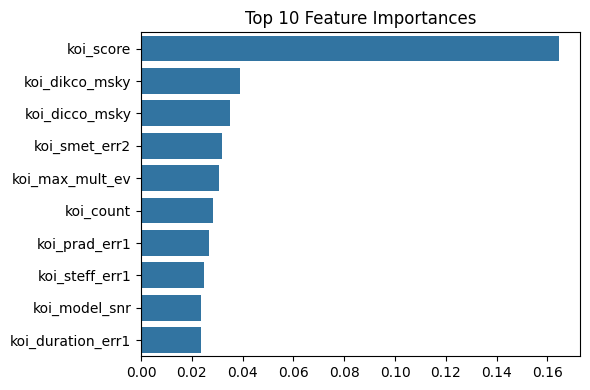

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on test data, printing accuracy and confusion matrix.
    Also plots feature importances.
    """
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {acc:.3f}")
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(6,4))
    sns.barplot(x=importances[indices][:10], y=np.array(feature_names)[indices][:10])
    plt.title("Top 10 Feature Importances")
    plt.tight_layout()
    plt.show()

# Evaluate the model
evaluate_model(rf_model, X_test, y_test)

In [ ]:
def predict_new(model, X_new):
    """
    Given a trained model and new data (as DataFrame or 2D array),
    return predicted class labels (1=planet, 0=non-planet).
    """
    return model.predict(X_new)

# Example: predict on first few test samples
example_preds = predict_new(rf_model, X_test.iloc[:5])
print("Predictions for new data (1=Confirmed, 0=Not):", example_preds)

Predictions for new data (1=Confirmed, 0=Not): [1 0 0 0 0]


In [ ]:
# Install required packages (astroquery for data, shap for explainability)
!pip install astroquery shap

# Import libraries and fix random seed for reproducibility
import numpy as np
import pandas as pd
import random
import sklearn
import shap
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive

random.seed(42)
np.random.seed(42)

# Print package versions to document environment
print("Astroquery version:", NasaExoplanetArchive.__module__.split('.')[2],
      "Scikit-learn:", sklearn.__version__, "SHAP:", shap.__version__)

# Query the KOI cumulative table from NASA Exoplanet Archive
koi_table = NasaExoplanetArchive.query_criteria(table="cumulative", select="*")
df = koi_table.to_pandas()
print("Downloaded KOI data with shape:", df.shape)

Astroquery version: nexsci Scikit-learn: 1.6.1 SHAP: 0.47.2
Downloaded KOI data with shape: (9564, 155)


In [ ]:
from sklearn.impute import SimpleImputer

# Define features to use (drop ID, name, string columns)
features = [
    'koi_period', 'koi_duration', 'koi_depth', 'koi_ror', 'koi_prad',
    'koi_teq', 'koi_insol', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smass'
]
# Some features (like koi_ror, koi_smass) might be NaN; we will impute later.

# Encode label: CONFIRMED = 1, else 0
df['label'] = (df['koi_disposition'] == 'CONFIRMED').astype(int)

# Subset data to features and label, dropping rows with missing label
df_model = df.dropna(subset=['label'])[features + ['label']]
print("Data subset shape (including label):", df_model.shape)

# Impute missing values with median
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(df_model[features]), columns=features)
y = df_model['label'].values

print("After imputation, number of missing values per feature:")
print(X.isnull().sum())

Data subset shape (including label): (9564, 12)
After imputation, number of missing values per feature:
koi_period      0
koi_duration    0
koi_depth       0
koi_ror         0
koi_prad        0
koi_teq         0
koi_insol       0
koi_steff       0
koi_slogg       0
koi_srad        0
koi_smass       0
dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Split into training and test sets (stratify to preserve class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Training set size:", X_train.shape[0], "  Test set size:", X_test.shape[0])

Training set size: 7651   Test set size: 1913


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define Random Forest with fixed random state
rf = RandomForestClassifier(random_state=42)

# Hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid = GridSearchCV(
    estimator=rf, param_grid=param_grid,
    cv=5, scoring='f1', n_jobs=-1, verbose=1
)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV F1 score:", grid.best_score_)
best_model = grid.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV F1 score: 0.7383927715006896


Confusion Matrix:
 [[1243  121]
 [ 146  403]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90      1364
           1       0.77      0.73      0.75       549

    accuracy                           0.86      1913
   macro avg       0.83      0.82      0.83      1913
weighted avg       0.86      0.86      0.86      1913



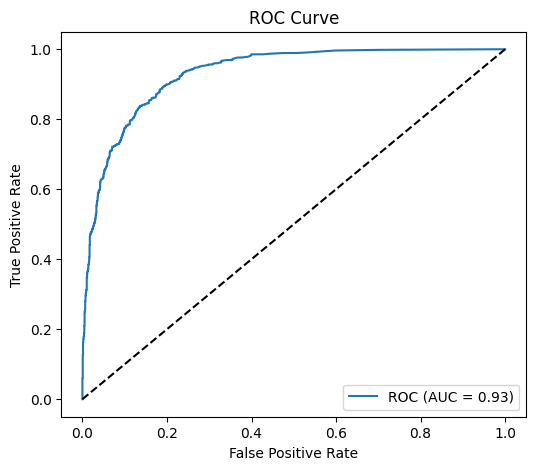

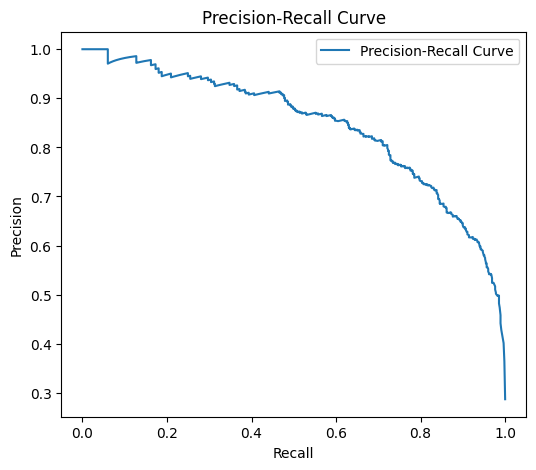

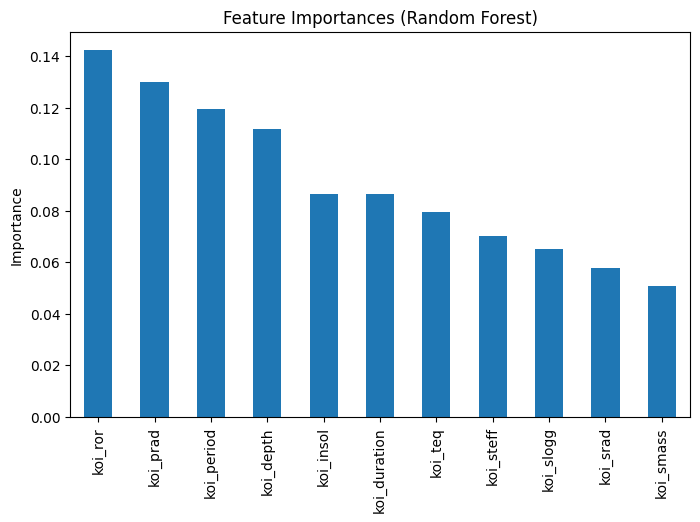

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# Predictions and probabilities on test set
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curve'); plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend(); plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.legend(); plt.show()

# Feature importance bar plot
importances = best_model.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
plt.figure(figsize=(8,5))
feat_imp.plot(kind='bar')
plt.title('Feature Importances (Random Forest)')
plt.ylabel('Importance')
plt.show()

<ipython-input-11-f0fd264ec4cb>:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train, feature_names=features)
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 640x480 with 0 Axes>

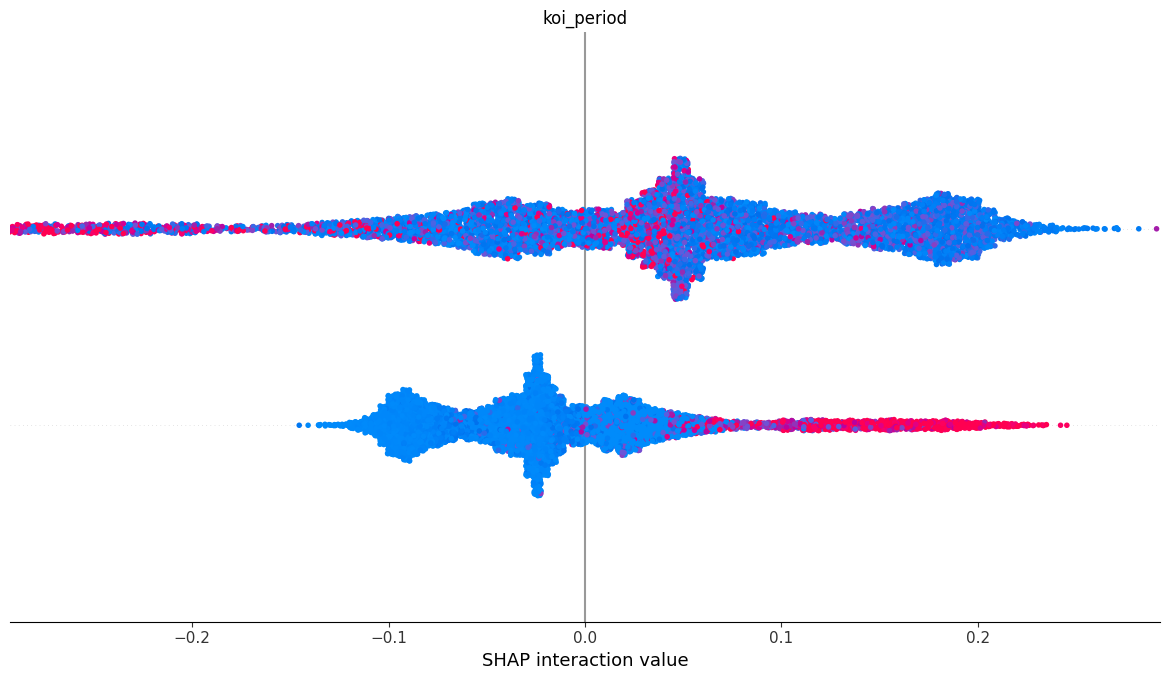

In [ ]:
# Compute SHAP values with additivity check disabled
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train, check_additivity=False)

# Plot SHAP summary - handle both binary and multiclass output
if isinstance(shap_values, list):
    # Multiclass (use class 1 = 'CONFIRMED' typically)
    shap.summary_plot(shap_values[1], X_train, feature_names=features)
else:
    # Binary classification (direct array)
    shap.summary_plot(shap_values, X_train, feature_names=features)

In [ ]:
# Step 1: Select features and target
features = [
    'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
    'koi_fpflag_ec', 'koi_period', 'koi_time0bk', 'koi_impact',
    'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol',
    'koi_model_snr', 'koi_steff', 'koi_slogg', 'koi_srad'
]
trained_features = features.copy()

target_col = 'koi_disposition'
df['label'] = df[target_col].map({'CONFIRMED': 1, 'FALSE POSITIVE': 0})  # binary classification

# ✅ Step 2: Preserve KOI name (INSERT THIS HERE)
id_col = 'kepoi_name' if 'kepoi_name' in df.columns else None
cols_to_keep = features + ['label']
if id_col:
    cols_to_keep.append(id_col)

df_model = df[cols_to_keep].copy()

# Step 3: Proceed with imputation and train-test split
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

X = df_model[trained_features]
y = df_model['label']
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=trained_features)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

In [ ]:
# Step 1: Select features and target
features = [
    'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
    'koi_fpflag_ec', 'koi_period', 'koi_time0bk', 'koi_impact',
    'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol',
    'koi_model_snr', 'koi_steff', 'koi_slogg', 'koi_srad'
]
trained_features = features.copy()

target_col = 'koi_disposition'
df['label'] = df[target_col].map({'CONFIRMED': 1, 'FALSE POSITIVE': 0})  # binary classification

# ✅ Step 2: Preserve KOI name (INSERT THIS HERE)
id_col = 'kepoi_name' if 'kepoi_name' in df.columns else None
cols_to_keep = features + ['label']
if id_col:
    cols_to_keep.append(id_col)

df_model = df[cols_to_keep].copy()

# Step 3: Proceed with imputation and train-test split
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

X = df_model[trained_features]
y = df_model['label']
imputer = SimpleImputer(strategy='mean')

# Fit and transform on X for training data
X_imputed_train_array = imputer.fit_transform(X)
# Convert imputed array back to DataFrame, explicitly setting columns
X_train = pd.DataFrame(X_imputed_train_array, columns=trained_features)

# Split y
y_train = y.loc[X_train.index] # Keep y aligned with X_train if original index matters, though train_test_split will handle it

# Split into train/test AFTER imputation of the full set to ensure imputer consistency
# Note: The previous approach split first then imputed train/test separately, which is also valid
# Let's revert to the split-then-impute approach which matches the original code's structure more closely
# But ensure imputation preserves column names or reassigns them correctly.

# Re-doing Step 3 & 4 following the original logic but fixing imputation DataFrame creation
X = df_model[trained_features]
y = df_model['label']

# Split into train/test sets first
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

imputer = SimpleImputer(strategy='mean')

# Fit imputer only on the training data
imputer.fit(X_train_raw)

# Transform both training and test data, converting back to DataFrame with correct columns
X_train = pd.DataFrame(imputer.transform(X_train_raw), columns=trained_features, index=X_train_raw.index)
X_test = pd.DataFrame(imputer.transform(X_test_raw), columns=trained_features, index=X_test_raw.index)

print(f"X_train columns: {X_train.columns.tolist()}")
print(f"X_test columns: {X_test.columns.tolist()}")

# The rest of the code from ipython-input-18-e41a0208fdbf should now work correctly
# as X_train, X_test, and later X_unconf will all be DataFrames with the same
# columns specified by 'trained_features' in the correct order.

X_train columns: ['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr', 'koi_steff', 'koi_slogg', 'koi_srad']
X_test columns: ['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr', 'koi_steff', 'koi_slogg', 'koi_srad']


# **Training 2nd model for comparision**

In [ ]:
# Drop rows where the target value is missing
df = df.dropna(subset=["koi_disposition"])

In [ ]:
# Re-encode labels if needed
df["koi_disposition"] = df["koi_disposition"].astype(str)

# Define X and y again after the NaN drop
df = df.drop(columns=["kepid", "kepoi_name"], errors="ignore")
X = df.drop(columns=["koi_disposition", "label"])
y = df["label"]

# Then split as usual
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score

# Convert to DataFrame if needed
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# Replace empty strings with NaN in features
X_train.replace('', np.nan, inplace=True)
X_test.replace('', np.nan, inplace=True)

# Select numeric columns only
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

# Remove numeric columns with all NaNs
numeric_cols = [col for col in numeric_cols if not X_train[col].isna().all()]

# Impute missing numeric values
imputer = SimpleImputer(strategy="mean")
X_train[numeric_cols] = imputer.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = imputer.transform(X_test[numeric_cols])

# CLEAN y_train: remove rows where y_train is NaN to avoid training errors
print("Number of NaNs in y_train before cleaning:", y_train.isna().sum())
not_nan_idx = y_train.notna()
X_train = X_train.loc[not_nan_idx]
y_train = y_train.loc[not_nan_idx]
print("Number of NaNs in y_train after cleaning:", y_train.isna().sum())

# Train Logistic Regression with cleaned data
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train[numeric_cols], y_train)

# Clean y_test before evaluation
print("Number of NaNs in y_test before cleaning:", y_test.isna().sum())
not_nan_idx_test = y_test.notna()
X_test = X_test.loc[not_nan_idx_test]
y_test = y_test.loc[not_nan_idx_test]
print("Number of NaNs in y_test after cleaning:", y_test.isna().sum())

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test[numeric_cols])
y_prob_lr = lr_model.predict_proba(X_test[numeric_cols])[:, 1]

print("=== Logistic Regression Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

Number of NaNs in y_train before cleaning: 1575
Number of NaNs in y_train after cleaning: 0
Number of NaNs in y_test before cleaning: 405
Number of NaNs in y_test after cleaning: 0
=== Logistic Regression Evaluation ===
Accuracy: 0.8421750663129973
F1 Score: 0.8023255813953488
ROC AUC: 0.9158024372486154

Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.84      0.87       939
         1.0       0.76      0.85      0.80       569

    accuracy                           0.84      1508
   macro avg       0.83      0.84      0.84      1508
weighted avg       0.85      0.84      0.84      1508



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
model_features = rf_model.feature_names_in_
print(model_features)

['kepid' 'ra' 'ra_err' 'dec' 'dec_err' 'koi_gmag' 'koi_gmag_err'
 'koi_rmag' 'koi_rmag_err' 'koi_imag' 'koi_imag_err' 'koi_zmag'
 'koi_zmag_err' 'koi_jmag' 'koi_jmag_err' 'koi_hmag' 'koi_hmag_err'
 'koi_kmag' 'koi_kmag_err' 'koi_kepmag' 'koi_kepmag_err' 'koi_count'
 'koi_num_transits' 'koi_max_sngle_ev' 'koi_max_mult_ev'
 'koi_bin_oedp_sig' 'koi_ldm_coeff4' 'koi_ldm_coeff3' 'koi_ldm_coeff2'
 'koi_ldm_coeff1' 'koi_model_snr' 'koi_model_dof' 'koi_model_chisq'
 'koi_time0bk' 'koi_time0bk_err1' 'koi_time0bk_err2' 'koi_eccen'
 'koi_eccen_err1' 'koi_eccen_err2' 'koi_longp' 'koi_longp_err1'
 'koi_longp_err2' 'koi_prad' 'koi_prad_err1' 'koi_prad_err2' 'koi_sma'
 'koi_sma_err1' 'koi_sma_err2' 'koi_impact' 'koi_impact_err1'
 'koi_impact_err2' 'koi_duration' 'koi_duration_err1' 'koi_duration_err2'
 'koi_ingress' 'koi_ingress_err1' 'koi_ingress_err2' 'koi_depth'
 'koi_depth_err1' 'koi_depth_err2' 'koi_period' 'koi_period_err1'
 'koi_period_err2' 'koi_ror' 'koi_ror_err1' 'koi_ror_err2' 'koi_dor'
 '

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler

X_train = X_train.dropna(axis=1, how='all')
X_test = X_test.dropna(axis=1, how='all')

# --- Step 1: Identify numeric features used for training ---
# (replace with your actual numeric features list used in training)
numeric_cols = X_train.select_dtypes(include=['number']).columns.tolist()

# --- Step 2: Fit imputer on training data ---
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train[numeric_cols])

# --- Step 3: Train models on imputed numeric features ---
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_imputed, y_train)

# --- Step 3a: Scale the imputed data ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)

# --- Step 3b: Train Logistic Regression with scaled data and more iterations ---
lr_model = LogisticRegression(max_iter=5000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# --- Step 4: Align and impute test data ---
# Align test data columns to training features
X_test_aligned = X_test.reindex(columns=numeric_cols)

# Impute missing values in test set using fitted imputer
X_test_imputed = imputer.transform(X_test_aligned)

# --- Step 5: Predict on test data ---
rf_preds = rf_model.predict(X_test_imputed)
rf_probs = rf_model.predict_proba(X_test_imputed)[:, 1]

X_test_scaled = scaler.transform(X_test_imputed)
lr_preds = lr_model.predict(X_test_scaled)
lr_probs = lr_model.predict_proba(X_test_scaled)[:, 1]

# --- Step 6: Evaluate models ---
print("=== Random Forest Evaluation ===")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print("F1 Score:", f1_score(y_test, rf_preds))
print("ROC AUC:", roc_auc_score(y_test, rf_probs))
print(classification_report(y_test, rf_preds))

print("\n=== Logistic Regression Evaluation ===")
print("Accuracy:", accuracy_score(y_test, lr_preds))
print("F1 Score:", f1_score(y_test, lr_preds))
print("ROC AUC:", roc_auc_score(y_test, lr_probs))
print(classification_report(y_test, lr_preds))

# --- Step 7: Model Comparison Summary ---
models = {
    "Random Forest": (y_test, rf_preds, rf_probs),
    "Logistic Regression": (y_test, lr_preds, lr_probs),
}

print("\n=== Model Comparison Summary ===")
for name, (true, pred, prob) in models.items():
    print(f"\n{name}:")
    print("  Accuracy:", round(accuracy_score(true, pred), 6))
    print("  F1 Score:", round(f1_score(true, pred), 6))
    print("  ROC AUC:", round(roc_auc_score(true, prob), 6))

=== Random Forest Evaluation ===
Accuracy: 0.9913793103448276
F1 Score: 0.9884444444444445
ROC AUC: 0.9994169843774272
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       939
         1.0       1.00      0.98      0.99       569

    accuracy                           0.99      1508
   macro avg       0.99      0.99      0.99      1508
weighted avg       0.99      0.99      0.99      1508


=== Logistic Regression Evaluation ===
Accuracy: 0.9907161803713528
F1 Score: 0.9876325088339223
ROC AUC: 0.9987815628561963
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       939
         1.0       0.99      0.98      0.99       569

    accuracy                           0.99      1508
   macro avg       0.99      0.99      0.99      1508
weighted avg       0.99      0.99      0.99      1508


=== Model Comparison Summary ===

Random Forest:
  Accuracy: 0.991379
  F1 Score: 0.988444
  ROC AUC

In [ ]:
from sklearn.metrics import confusion_matrix

# Final confusion matrices
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, rf_preds))

print("\nLogistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, lr_preds))

Random Forest Confusion Matrix:
[[939   0]
 [ 13 556]]

Logistic Regression Confusion Matrix:
[[935   4]
 [ 10 559]]
